<a href="https://www.kaggle.com/code/liammohan/using-weather-to-predict-california-s-air-quality?scriptVersionId=154461621" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from os.path import exists
from google.cloud import bigquery
from bq_helper import BigQueryHelper

In [2]:
# Using Google's Big Query to pull EPA Air Quality data set
bq_assistant = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")

In [3]:
TEMP_QUERY = """
        SELECT 
            date_local, 
            temp_daily.latitude, 
            temp_daily.longitude, 
            temp_daily.arithmetic_mean AS avg_temp
        FROM 
            `bigquery-public-data.epa_historical_air_quality.temperature_daily_summary` AS temp_daily
        WHERE 
            state_name = "California"
            AND sample_duration = "1 HOUR"
            AND observation_count > 8
    """
temp_df = bq_assistant.query_to_pandas(TEMP_QUERY)
temp_df = temp_df.astype({'date_local':'str'})
print(temp_df.head())

   date_local  latitude  longitude   avg_temp
0  1990-01-14  34.48974 -120.04692  51.250000
1  1990-02-22  34.48974 -120.04692  68.750000
2  1990-08-11  34.48974 -120.04692  68.916667
3  1990-05-07  34.48974 -120.04692  63.125000
4  1990-07-07  34.48974 -120.04692  64.833333


In [4]:
#looking into range of realistic temperature values
print(f"Starting range of temp values: {temp_df['avg_temp'].min()} ,{temp_df['avg_temp'].max()} \n")

Starting range of temp values: -58.0 ,440.857143 



All values above 120 degrees F are deemed too hot to be a realistic average temperature value. Also, all values below -40 deg F and all values 0 or less coming from Southern CA are unrealistic values for an average temperature.  

In [5]:
# Data cleaning for temperature query

#remove all values above 120 as this too hot to be a realistic value
temp_df = temp_df[temp_df['avg_temp'] <= 120]

#remove all values less than -40 deg
temp_df = temp_df[temp_df['avg_temp'] > -40]

#remove values 0 or less coming from southern CA
temp_df = temp_df[(temp_df['avg_temp'] > 0) | (temp_df['latitude'] > 35)]

print(f"New range of temp values: {temp_df['avg_temp'].min()} ,{temp_df['avg_temp'].max()} \n")

New range of temp values: -10.125 ,119.458333 



In [6]:
WIND_QUERY = """
        SELECT 
            date_local, 
            latitude, 
            longitude, 
            arithmetic_mean AS avg_wind
        FROM 
            `bigquery-public-data.epa_historical_air_quality.wind_daily_summary` AS wind_daily
        WHERE 
            state_name = "California"
    """
wind_df = bq_assistant.query_to_pandas(WIND_QUERY)
wind_df = wind_df.astype({'date_local':'str'})

# data cleaning
wind_df = wind_df[wind_df['avg_wind']<= 50]
print(wind_df.head())

   date_local   latitude   longitude  avg_wind
0  1992-01-02  41.561111 -124.082778  5.950000
1  1992-01-14  41.561111 -124.082778  3.366667
2  1992-01-18  41.561111 -124.082778  5.516667
3  1992-01-25  41.561111 -124.082778  4.975000
4  1992-01-29  41.561111 -124.082778  7.537500


In [7]:
PRESSURE_QUERY = """
        SELECT 
            date_local, 
            latitude, 
            longitude, 
            arithmetic_mean AS avg_pressure
        FROM 
            `bigquery-public-data.epa_historical_air_quality.pressure_daily_summary` AS pressure_daily
        WHERE 
            state_name = "California"
    """
pressure_df = bq_assistant.query_to_pandas(PRESSURE_QUERY)
pressure_df = pressure_df.astype({'date_local':'str'})

#data cleaning: barometric pressure (mb) is assumed to be greater than 870 mb and less that 1084 mb since these are the lowest and highest measured barometric pressures on earth respectively. 
pressure_df = pressure_df[(pressure_df['avg_pressure'] > 840) & (pressure_df['avg_pressure'] < 1084)]
print(pressure_df.head())

   date_local   latitude  longitude  avg_pressure
0  2023-01-01  34.291257 -118.79765    974.750000
1  2023-01-02  34.291257 -118.79765    981.250000
2  2023-01-03  34.291257 -118.79765    983.541667
3  2023-01-04  34.291257 -118.79765    984.291667
4  2023-01-05  34.291257 -118.79765    984.208333


In [8]:
CO_QUERY = """
        SELECT 
            date_local, 
            latitude, 
            longitude, 
            arithmetic_mean AS avg_co
        FROM 
            `bigquery-public-data.epa_historical_air_quality.co_daily_summary` AS co_daily
        WHERE 
            state_name = "California"
            AND sample_duration = "1 HOUR"
            AND observation_count > 8
            AND units_of_measure = "Parts per million"
    """
co_df = bq_assistant.query_to_pandas(CO_QUERY)
co_df = co_df.astype({'date_local':'str'})

#remove negative values
co_df = co_df[co_df['avg_co'] >= 0]
print(co_df.head())

   date_local  latitude  longitude    avg_co
0  1995-01-01   37.6849  -121.7659  1.004167
1  1995-01-02   37.6849  -121.7659  0.950000
2  1995-01-03   37.6849  -121.7659  1.356522
3  1995-01-04   37.6849  -121.7659  0.825000
4  1995-01-05   37.6849  -121.7659  0.634783


In [9]:

LEAD_QUERY = """
        SELECT 
            date_local, 
            latitude, 
            longitude, 
            arithmetic_mean AS avg_lead
        FROM 
            `bigquery-public-data.epa_historical_air_quality.lead_daily_summary` AS lead_daily
        WHERE 
            state_name = "California"
            AND sample_duration = "24 HOUR"
            AND units_of_measure = "Micrograms/cubic meter (LC)"
    """
lead_df = bq_assistant.query_to_pandas(LEAD_QUERY)
lead_df = lead_df.astype({'date_local':'str'})   

#remove negatives
lead_df = lead_df[lead_df['avg_lead'] >= 0]
print(lead_df.head())

   date_local  latitude  longitude  avg_lead
0  2009-03-26  32.67618 -115.48307     0.036
1  2009-04-01  32.67618 -115.48307     0.038
2  2009-04-07  32.67618 -115.48307     0.031
3  2009-05-07  32.67618 -115.48307     0.028
4  2009-05-31  32.67618 -115.48307     0.032


In [10]:
NO2_QUERY = """
        SELECT 
            date_local, 
            latitude, 
            longitude, 
            arithmetic_mean AS avg_no2
        FROM 
            `bigquery-public-data.epa_historical_air_quality.no2_daily_summary` AS no2_daily
        WHERE 
            state_name = "California"
            AND observation_percent = 100
    """
no2_df = bq_assistant.query_to_pandas(NO2_QUERY)
no2_df = no2_df.astype({'date_local':'str'})

# remove negative values
no2_df = no2_df[no2_df['avg_no2']>=0]  
print(no2_df.head())

   date_local   latitude   longitude  avg_no2
0  1991-03-22  37.011894 -122.194413     10.0
1  1991-03-23  37.011894 -122.194413     10.0
2  1991-03-24  37.011894 -122.194413     10.0
3  1991-03-25  37.011894 -122.194413     10.0
4  1991-03-28  37.011894 -122.194413     10.0


In [11]:

SO2_QUERY = """
        SELECT 
            date_local, 
            latitude, 
            longitude, 
            arithmetic_mean AS avg_so2
        FROM 
            `bigquery-public-data.epa_historical_air_quality.so2_daily_summary` AS so2_daily
        WHERE 
            state_name = "California"
    """
so2_df = bq_assistant.query_to_pandas(SO2_QUERY)
so2_df = so2_df.astype({'date_local':'str'})

#remove negative values
so2_df = so2_df[so2_df['avg_so2']>=0]    
print(so2_df.head())

   date_local   latitude   longitude   avg_so2
0  1990-01-01  37.936013 -122.026154  0.000000
1  1990-01-02  37.936013 -122.026154  0.000000
2  1990-01-03  37.936013 -122.026154  3.333333
3  1990-01-04  37.936013 -122.026154  6.086957
4  1990-01-05  37.936013 -122.026154  4.166667


In [12]:
O3_QUERY = """
        SELECT 
            date_local, 
            latitude, 
            longitude, 
            arithmetic_mean AS avg_o3
        FROM 
            `bigquery-public-data.epa_historical_air_quality.o3_daily_summary` AS o3_daily
        WHERE 
            state_name = "California"
    """
o3_df = bq_assistant.query_to_pandas(O3_QUERY)
#     o3_df.to_csv(path,index=False)
o3_df = o3_df.astype({'date_local':'str'})
o3_df = o3_df[o3_df['avg_o3']>=0]  
print(o3_df.head())

   date_local   latitude   longitude    avg_o3
0  1993-01-03  38.342606 -120.764426  0.018059
1  1993-01-05  38.342606 -120.764426  0.012706
2  1993-01-08  38.342606 -120.764426  0.025412
3  1993-01-09  38.342606 -120.764426  0.032412
4  1993-01-12  38.342606 -120.764426  0.027353


In [13]:
PM10_QUERY = """
        SELECT 
            date_local, 
            latitude, 
            longitude, 
            arithmetic_mean AS avg_pm10
        FROM 
            `bigquery-public-data.epa_historical_air_quality.pm10_daily_summary` AS pm10_daily
        WHERE 
            state_name = "California"
    """
pm10_df = bq_assistant.query_to_pandas(PM10_QUERY)
pm10_df = pm10_df.astype({'date_local':'str'})

#data cleaning
pm10_df = pm10_df[pm10_df['avg_pm10']>=0]
pm10_df = pm10_df[pm10_df['avg_pm10']<1000]
print(pm10_df.head())

   date_local  latitude   longitude  avg_pm10
0  1991-01-06   36.8166 -118.211207       8.0
1  1991-01-12   36.8166 -118.211207      12.0
2  1991-01-18   36.8166 -118.211207       6.0
3  1991-01-24   36.8166 -118.211207      11.0
4  1991-01-30   36.8166 -118.211207      30.0


In [14]:
PM25_QUERY = """
        SELECT 
            date_local, 
            latitude, 
            longitude, 
            arithmetic_mean AS avg_pm25
        FROM 
            `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary` AS pm25_daily
        WHERE 
            state_name = "California"
    """
pm25_df = bq_assistant.query_to_pandas(PM25_QUERY)
pm25_df = pm25_df.astype({'date_local':'str'})

# pm25 data cleaning 
pm25_df = pm25_df[pm25_df['avg_pm25']>=0]
print(pm25_df.head())

   date_local   latitude   longitude  avg_pm25
0  2019-09-12  37.701222 -121.903019       6.8
1  2019-09-13  37.701222 -121.903019       8.7
2  2019-12-05  37.701222 -121.903019      10.1
3  2019-03-15  37.701222 -121.903019       6.2
4  2019-07-08  37.701222 -121.903019       5.3


In [15]:
#return random sample of tuples from dataframe with n = sample_size
def sample_data(df, col_key1, col_key2, sample_size = 10000, seed = 777):
    np.random.seed(seed)
    rand_permutation = np.random.permutation(np.arange(0,df.shape[0]))[:sample_size]
    return df.iloc[rand_permutation]

#return line of best fit and r squared for linear regression analysis
def reg_stats(df, col_key1, col_key2):
    X = df.iloc[:, df.columns.get_loc(col_key1)].values.reshape(-1, 1)  
    Y = df.iloc[:, df.columns.get_loc(col_key2)].values.reshape(-1, 1)  
    reg = LinearRegression()
    reg.fit(X,Y)
    r2 = reg.score(X,Y)
    slope = reg.coef_[0][0]
    intercept = reg.intercept_[0]
    return [slope, intercept, r2]

# Average Temperature vs Air Pollution
First, we look at the relationship between the daily average temperature and the criteria air pollutants through linear regression analysis. 

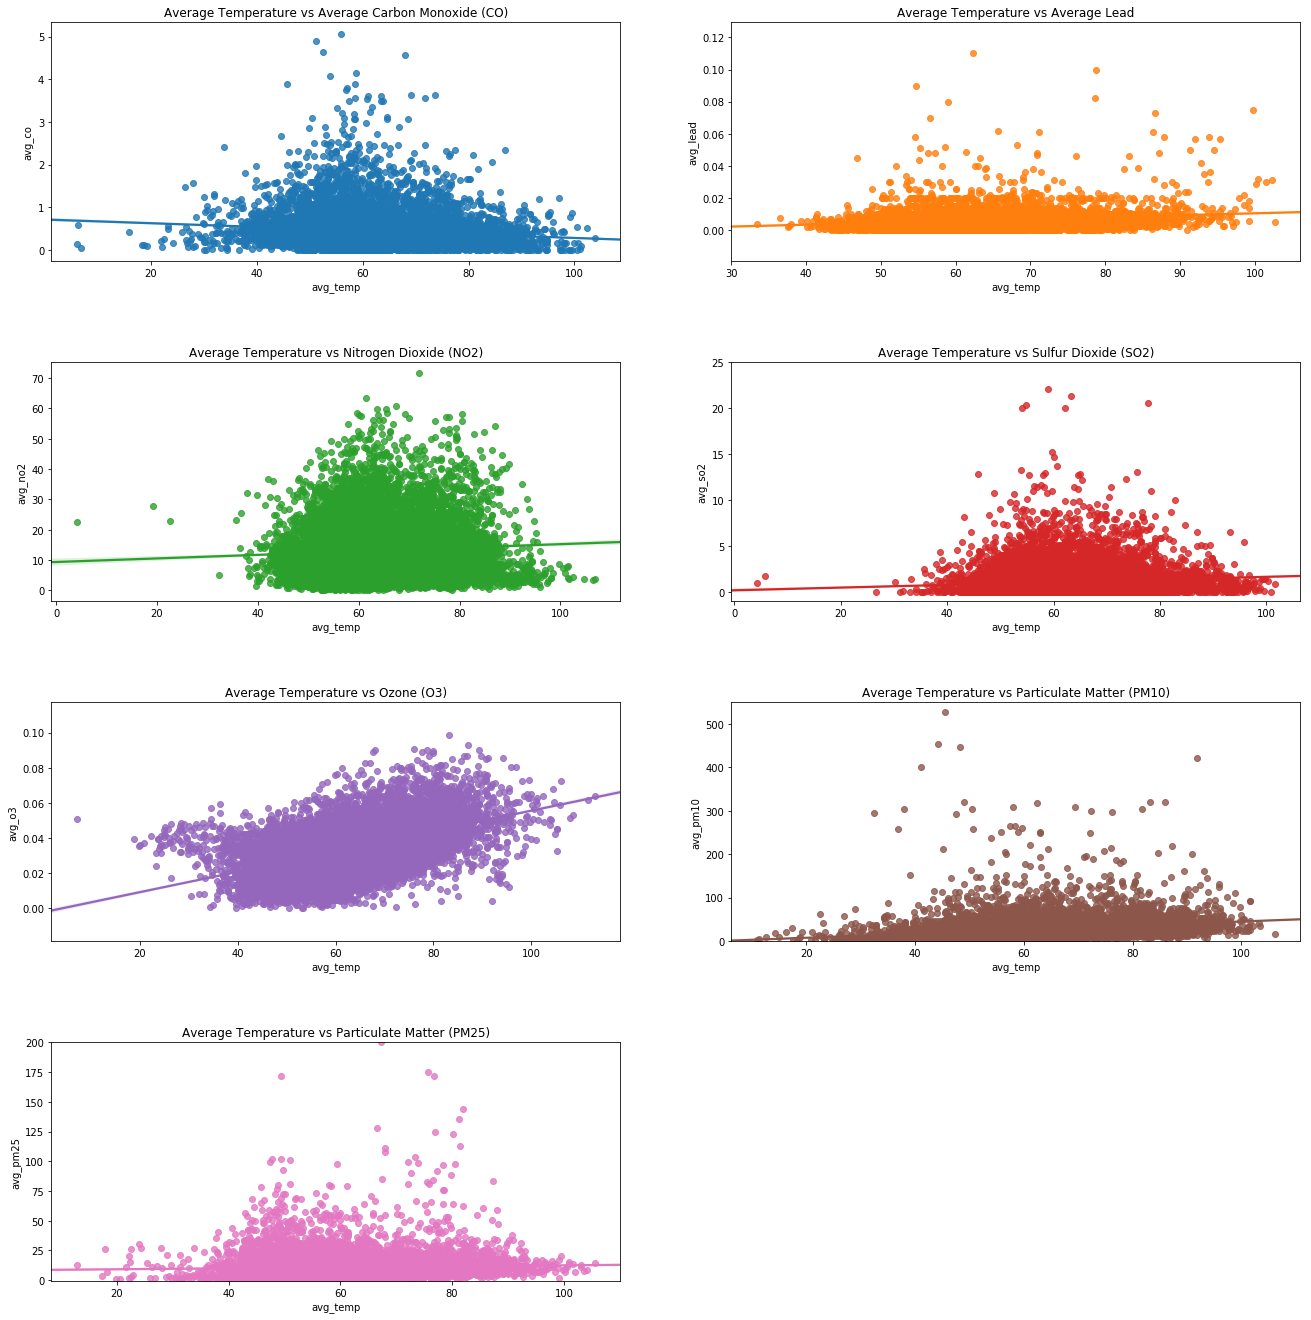

  Pollutant     Slope  Intercept        R2
0        CO -0.004285   0.711908  0.013866
1      Lead  0.000118  -0.001199  0.034559
2       NO2  0.056769   9.452917  0.003640
3       SO2  0.014091   0.221427  0.007324
4        O3  0.000573  -0.001977  0.246571
5      PM10  0.454258  -1.450885  0.047880
6      PM25  0.021676   9.642912  0.000453


In [16]:
regstats=[]
fig, axes = plt.subplots(4, 2, figsize = (20,20))
fig.tight_layout(pad=8.0)

#CO
df = pd.merge(temp_df, co_df, on=['date_local','latitude','longitude'])
df_sample = sample_data(df, 'avg_temp', 'avg_co', sample_size = 10000)
sns.regplot(ax = axes[0][0] ,x='avg_temp', y='avg_co', data=df_sample, fit_reg=True).set(title="Average Temperature vs Average Carbon Monoxide (CO)")
regstats.append(reg_stats(df, 'avg_temp', 'avg_co'))

#Lead
df = pd.merge(temp_df, lead_df, on=['date_local','latitude','longitude'])
df_sample = sample_data(df, 'avg_temp', 'avg_lead', sample_size = 10000)
regstats.append(reg_stats(df, 'avg_temp', 'avg_lead'))
sns.regplot(ax = axes[0][1] ,x='avg_temp', y='avg_lead', data=df_sample, fit_reg=True).set(title="Average Temperature vs Average Lead")

#Nitrogen Dioxide 
df = pd.merge(temp_df, no2_df, on=['date_local','latitude','longitude'])
df_sample = sample_data(df, 'avg_temp', 'avg_no2', sample_size = 10000)
regstats.append(reg_stats(df, 'avg_temp', 'avg_no2'))
sns.regplot(ax = axes[1][0] ,x='avg_temp', y='avg_no2', data=df_sample, fit_reg=True).set(title="Average Temperature vs Nitrogen Dioxide (NO2)")

#Sulfur Dioxide 
df = pd.merge(temp_df, so2_df, on=['date_local','latitude','longitude'])
df = df.dropna(subset=['avg_temp','avg_so2'])
df_sample = sample_data(df, 'avg_temp', 'avg_so2', sample_size = 10000)
regstats.append(reg_stats(df, 'avg_temp', 'avg_so2'))
sns.regplot(ax = axes[1][1] ,x='avg_temp', y='avg_so2', data=df_sample, fit_reg=True).set(title="Average Temperature vs Sulfur Dioxide (SO2)")
axes[1][1].set(ylim=(-1, 25))

#Ozone 
df = pd.merge(temp_df, o3_df, on=['date_local','latitude','longitude'])
df = df.dropna(subset=['avg_temp','avg_o3'])
df_sample = sample_data(df, 'avg_temp', 'avg_o3', sample_size = 10000)
regstats.append(reg_stats(df, 'avg_temp', 'avg_o3'))
sns.regplot(ax = axes[2][0] ,x='avg_temp', y='avg_o3', data=df_sample, fit_reg=True).set(title="Average Temperature vs Ozone (O3)")

#Particulate matter
df = pd.merge(temp_df, pm10_df, on = ['date_local', 'latitude', 'longitude'])
df = df.dropna(subset=['avg_temp','avg_pm10'])
df_sample = sample_data(df, 'avg_temp', 'avg_pm10', sample_size = 10000)
regstats.append(reg_stats(df, 'avg_temp', 'avg_pm10'))
sns.regplot(ax = axes[2][1] ,x='avg_temp', y='avg_pm10', data=df_sample, fit_reg=True).set(title="Average Temperature vs Particulate Matter (PM10)")
axes[2][1].set(ylim=(-1, 550))

#Particulate matter
df = pd.merge(temp_df, pm25_df, on = ['date_local', 'latitude', 'longitude'])
df = df.dropna(subset=['avg_temp','avg_pm25'])
df_sample = sample_data(df, 'avg_temp', 'avg_pm25', sample_size = 10000)
regstats.append(reg_stats(df, 'avg_temp', 'avg_pm25'))
sns.regplot(ax = axes[3][0], x='avg_temp', y='avg_pm25', data=df_sample, fit_reg=True).set(title="Average Temperature vs Particulate Matter (PM25)")
axes[3][0].set(ylim=(-1, 200))
axes[3][1].remove()
plt.show()

#compile regression statistics
regstats = np.array(regstats)
d = {'Pollutant':['CO','Lead','NO2','SO2','O3','PM10','PM25'], 'Slope':regstats[:,0], 'Intercept':regstats[:,1], 'R2':regstats[:,2]}
regression = pd.DataFrame(data = d)
regression = regression[['Pollutant', 'Slope', 'Intercept', 'R2']]
print(regression)

Temperature appears to have the strongest linear relationship with Ozone (O3), and has a weaker linear relationship with Carbon Monoxide (CO), Lead, Nitrous Dioxide (NO2), Sulfur Dioxide (SO2), and particulate matter (PM10 & PM25). 

We observe a **positive correlation** between all of the average criteria air pollutants and temperature, except for Carbon Monoxide. Other than CO, this means **average concentrations of pollutants increase as the average temperature increases**. 

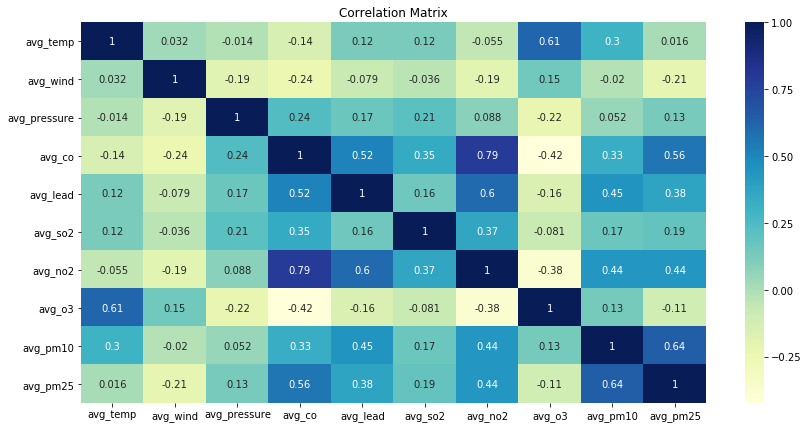

temperature correlations: 
 avg_temp        1.000000
avg_wind        0.031579
avg_pressure   -0.014407
avg_co         -0.140832
avg_lead        0.122388
avg_so2         0.124233
avg_no2        -0.054542
avg_o3          0.612877
avg_pm10        0.303411
avg_pm25        0.015841
Name: avg_temp, dtype: float64


In [17]:
#inner join all daily summaries 
df_combined = pd.merge(temp_df, co_df, on=['date_local','latitude','longitude'])
df_combined = pd.merge(df_combined, wind_df, on=['date_local','latitude','longitude'])
df_combined = pd.merge(df_combined, pressure_df, on=['date_local','latitude','longitude'])
df_combined = pd.merge(df_combined, lead_df, how='outer', on=['date_local','latitude','longitude'])
df_combined = pd.merge(df_combined, so2_df, how='outer', on=['date_local','latitude','longitude'])
df_combined = pd.merge(df_combined, no2_df, how='outer', on=['date_local','latitude','longitude'])
df_combined = pd.merge(df_combined, pm10_df, how='outer', on=['date_local','latitude','longitude'])
df_combined = pd.merge(df_combined, o3_df, how='outer', on=['date_local','latitude','longitude'])
df_combined = pd.merge(df_combined, pm25_df, how='outer', on=['date_local','latitude','longitude'])

# correlation matrix
df = df_combined[['avg_temp','avg_wind','avg_pressure','avg_co', 'avg_lead', 'avg_so2','avg_no2', 'avg_o3', 'avg_pm10', 'avg_pm25']]
corr = df.corr()

#plot
fig, ax = plt.subplots(figsize=(14,7))
dataplot = sns.heatmap(corr, cmap="YlGnBu", annot=True).set(title="Correlation Matrix")
plt.show()

print(f"temperature correlations: \n {corr['avg_temp']}")

We can see that the temperature has the strongest positive correlation with Ozone, and has a slight positive correlation with all other pollutants except for CO and pm2.5.

# Wind Analysis


First, we visualize the relationship between the average wind readings and the average measured values of the 7 criteria air pollutants we observe. Then, we can perform regression analysis to model these relationships. 

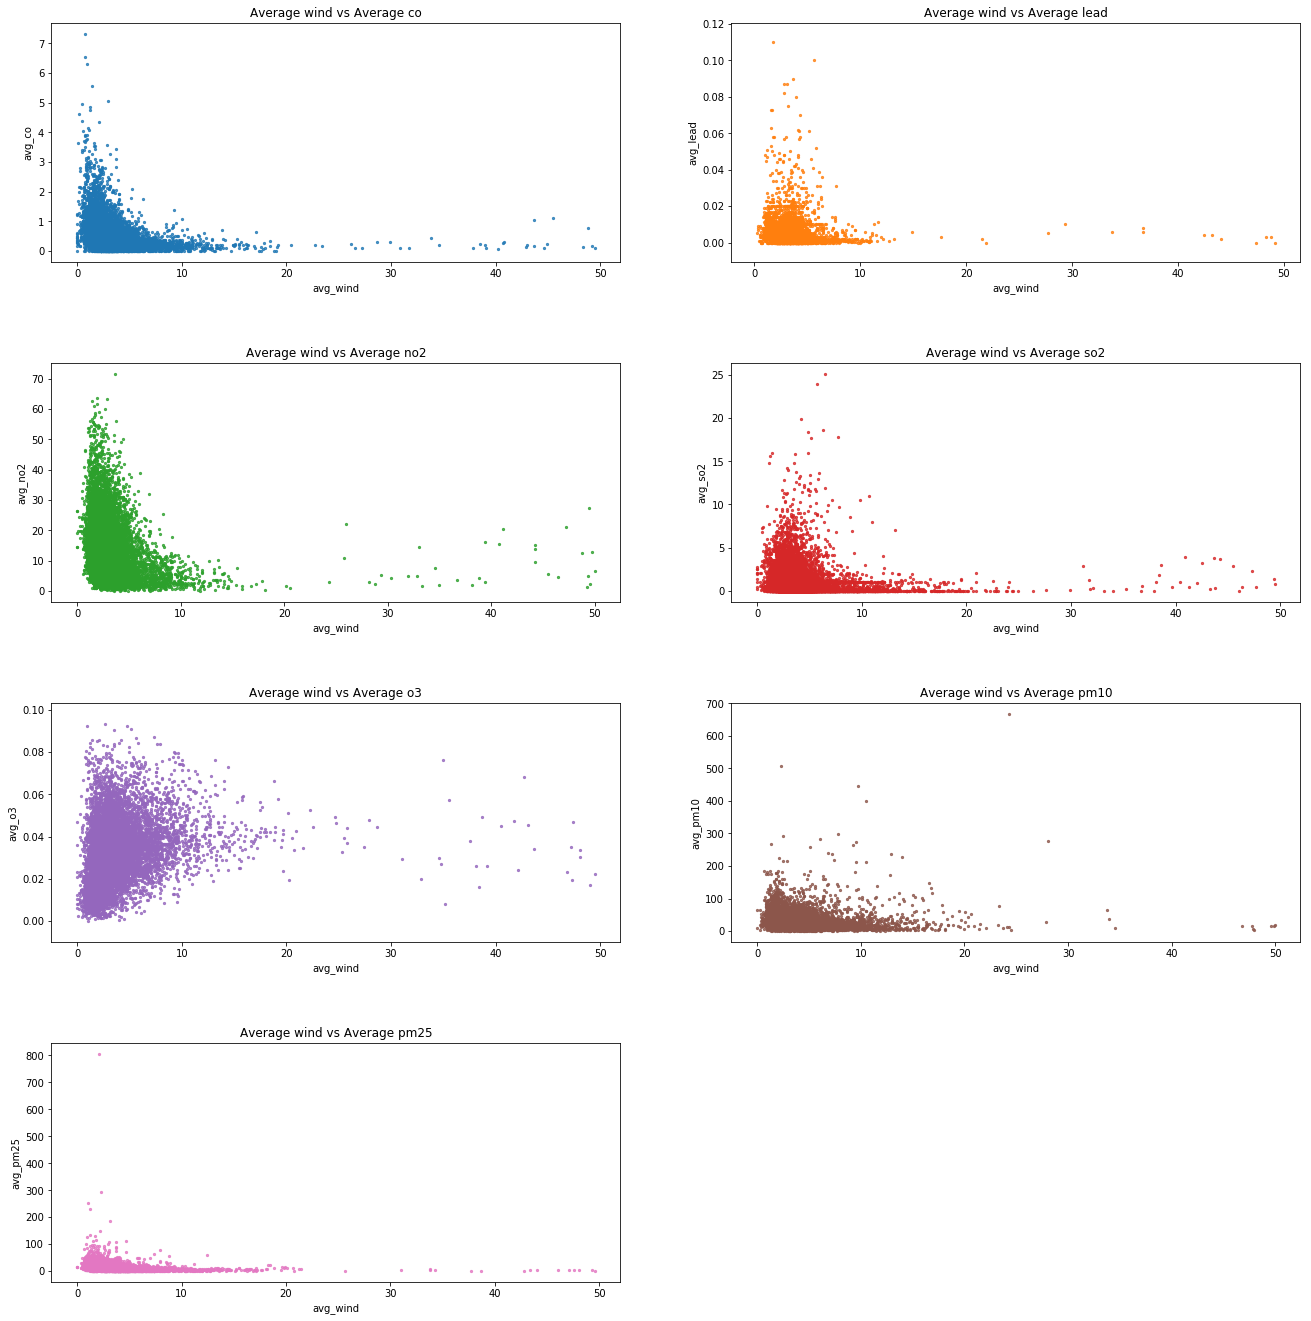

In [18]:
df_list = [co_df, lead_df, no2_df, so2_df, o3_df, pm10_df, pm25_df]

fig, axes = plt.subplots(4, 2, figsize = (20,20))
fig.tight_layout(pad=8.0)

r = -1 # used to get subplot row right
for i, df in enumerate(df_list): 
    y_col = df.columns[3]
    df = pd.merge(wind_df, df, on=['date_local','latitude','longitude'])
    df_sample = sample_data(df, 'avg_wind', y_col, sample_size = 10000)
    if i%2 == 0: 
        r += 1
    sns.regplot(ax = axes[r][int(i%2!=0)], x='avg_wind', y=y_col, data=df_sample, fit_reg=False, scatter_kws={'s':5}).set(title=f"Average wind vs Average {y_col[4:]}")

axes[3][1].remove()

There appears to be a **nonlinear relationship** between most of the criteria air pollutants and the average wind readings. The relationship resembles a **negative exponential** curve where the pollutants decrease exponentially the higher the average wind reading. Therefore, we use an exponential curve fitting method for most of the criteria pollutants relationship with the wind. We use mean squared error (MSE) and normalized mean squared error (NMSE) to measure the potential fit of our regression models. 

In [19]:
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

[ 1.12999903 -0.28104145]
Curve Fit Model: CO = 1.13*exp(-0.28*W)
Mean Squared Error: 0.19612453339045485
Normalized Mean Squared Error: 0.035885955377518375


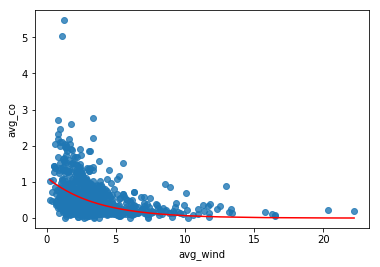

In [20]:
#CO analysis
np.random.seed(777)
def f(x, a, b):
    return a*np.exp(b*x)

df = pd.merge(wind_df, co_df, on=['date_local','latitude','longitude'])
#data cleaning
df = df[df['avg_co']>0]
df = df[df['avg_wind']<25]
#sample data
df_sample = sample_data(df, 'avg_wind', 'avg_co', sample_size = 1000)
df_sample = df_sample.sort_values(by='avg_wind', ascending=False)
x = df_sample['avg_wind'].astype(float)
y = df_sample['avg_co'].astype(float)
popt, pcov = curve_fit(f,x,y)
print(popt)
sns.regplot(x = 'avg_wind', y='avg_co', data = df_sample, fit_reg = False)
plt.plot(x, f(x, *popt),c='red')


mse = mean_squared_error(y, f(x, *popt))
nmse = mse/(np.max(y)-np.min(y))
print(f"Curve Fit Model: CO = {round(popt[0],5)}*exp({round(popt[1],2)}*W)")
print(f"Mean Squared Error: {mse}")
print(f"Normalized Mean Squared Error: {nmse}")

The exponential curve fitting regression model is a good fit with a Relative Mean Squared Error of 0.04. 

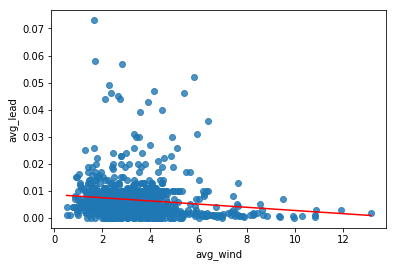

Curve Fit Model: LEAD = 0.0087+ -0.0006*W
Mean Squared Error: 5.048170606103436e-05
Normalized Mean Squared Error: 0.0006915302200141693


In [21]:
#Lead
def f(x, a, b):
    return a + b*x

df = pd.merge(wind_df, lead_df, on=['date_local','latitude','longitude'])
df = df[df['avg_wind'] < 25]
df_sample = sample_data(df, 'avg_wind', 'avg_lead', sample_size = 1000)
df_sample = df_sample.sort_values(by='avg_wind', ascending=False)
x = df_sample['avg_wind'].astype(float)
y = df_sample['avg_lead'].astype(float)
popt, pcov = curve_fit(f,x,y)
sns.regplot(x = 'avg_wind', y='avg_lead', data = df_sample, fit_reg = False)
plt.plot(x, f(x, *popt),c='red')
plt.show()

mse = mean_squared_error(y, f(x, *popt))
nmse = mse/(np.max(y)-np.min(y))
print(f"Curve Fit Model: LEAD = {round(popt[0],4)}+ {round(popt[1],4)}*W")
print(f"Mean Squared Error: {mse}")
print(f"Normalized Mean Squared Error: {nmse}")

The relationship between Lead and Wind is more linear, with a very slight decrease in the average lead concentration as the average wind speed measurement increases. There are higher average lead concentration values where the average wind speed is lower. This gives us a very low normalized mean squared error, indicating this model is strong. 

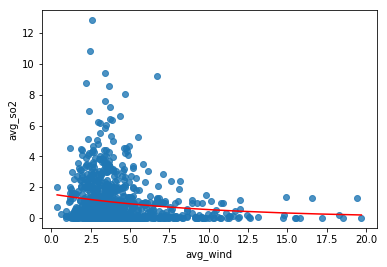

[ 1.55958658 -0.10533172]
Curve Fit Model: SO2 = 1.56*exp(-0.11*W)
Mean Squared Error: 2.0770320649753407
Normalized Mean Squared Error: 0.1619067365317104


In [22]:
#so2
def f(x, a, b):
    return a*np.exp(b*x)

df = pd.merge(wind_df, so2_df, on=['date_local','latitude','longitude'])
df_sample = sample_data(df, 'avg_wind', 'avg_so2', sample_size = 1000)
df_sample = df_sample.sort_values(by='avg_wind', ascending=False)
df_sample = df_sample[df_sample['avg_wind']<20]
x = df_sample['avg_wind'].astype(float)
y = df_sample['avg_so2'].astype(float)
popt, pcov = curve_fit(f,x,y)
sns.regplot(x = 'avg_wind', y='avg_so2', data = df_sample, fit_reg = False)
plt.plot(x, f(x, *popt),c='red')
plt.show()

print(popt)
mse = mean_squared_error(y, f(x, *popt))
nmse = mse/(np.max(y)-np.min(y))
print(f"Curve Fit Model: SO2 = {round(popt[0],2)}*exp({round(popt[1],2)}*W)")
print(f"Mean Squared Error: {mse}")
print(f"Normalized Mean Squared Error: {nmse}")

On average, we see a decrease in average sulfur dioxide as the average wind increases. This follows a slightly negative exponential curve with a relatively low normalized mean squared error of < 0.13. 

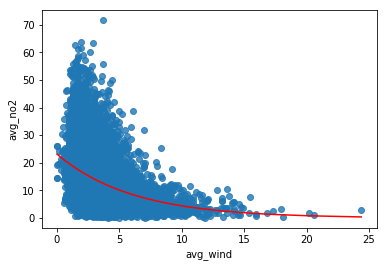

Curve Fit Model: NO2 = 23.17*exp(-0.17*W)
Mean Squared Error: 83.80545295091443
Normalized Mean Squared Error: 1.1714216013772232


In [23]:
#no2
def f(x, a, b):
    return a*np.exp(b*x)

df = pd.merge(wind_df, no2_df, on=['date_local','latitude','longitude'])
df_sample = sample_data(df, 'avg_wind', 'avg_no2', sample_size = 10000, seed=777)
df_sample = df_sample.sort_values(by='avg_wind', ascending=False)
df_sample = df_sample[df_sample['avg_wind']<25]
x = df_sample['avg_wind'].astype(float)
y = df_sample['avg_no2'].astype(float)
popt, pcov = curve_fit(f,x,y)
sns.regplot(x = 'avg_wind', y='avg_no2', data = df_sample, fit_reg = False)
plt.plot(x, f(x, *popt),c='red')
plt.show()
mse = mean_squared_error(y, f(x, *popt))
nmse = mse/(np.max(y)-np.min(y))
print(f"Curve Fit Model: NO2 = {round(popt[0],2)}*exp({round(popt[1],2)}*W)")
print(f"Mean Squared Error: {mse}")
print(f"Normalized Mean Squared Error: {nmse}")

Visually, the average nitrous dioxide concentration follows a negative exponential curve, decreasing rapidly as the average wind increases. The curve model, has a slightly higher normalized mean squared error of aroung 1.3 because of the higher variance of $NO_2$ readings. However, this still indicates that this is a strong predictive model. 

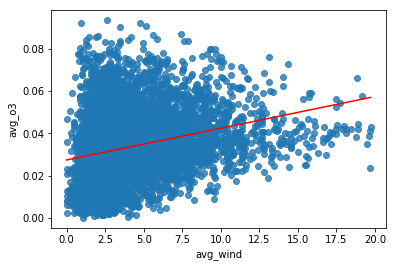

Curve Fit Model: O3 = 0.0015W + 0.0274
Mean Squared Error: 0.00018799688218874665
Normalized Mean Squared Error: 0.0020138279668435576


In [24]:
#O3
def f(x,a,b):
    return a+b*x

df = pd.merge(wind_df, o3_df, on=['date_local','latitude','longitude'])
df_sample = sample_data(df, 'avg_wind', 'avg_o3', sample_size = 10000)
df_sample = df_sample.sort_values(by='avg_wind', ascending=False)
df_sample = df_sample[df_sample['avg_wind']<20]
x = df_sample['avg_wind'].astype(float)
y = df_sample['avg_o3'].astype(float)
popt, pcov = curve_fit(f,x,y)
sns.regplot(x = 'avg_wind', y='avg_o3', data = df_sample, fit_reg = False)
plt.plot(x, f(x, *popt),c='red')
plt.show()
mse = mean_squared_error(y, f(x, *popt))
nmse = mse/(np.max(y)-np.min(y))
print(f"Curve Fit Model: O3 = {round(popt[1],4)}W + {round(popt[0],4)}")
print(f"Mean Squared Error: {mse}")
print(f"Normalized Mean Squared Error: {nmse}")

For Ozone, we observe a more linear relationship so we use linear regression. This is a strong predictive model with a low normalized error of 0.0002.

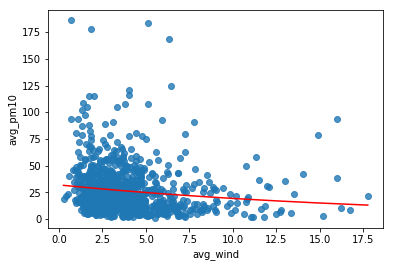

Curve Fit Model: PM10 = 31.9439*exp(-0.0504*W)
Mean Squared Error: 463.6678643503118
Normalized Mean Squared Error: 2.506312780271956


In [25]:
#PM10
def f(x, a, b):
    return a*np.exp(b*x)

df = pd.merge(wind_df, pm10_df, on=['date_local','latitude','longitude'])
df_sample = sample_data(df, 'avg_wind', 'avg_pm10', sample_size = 1000, seed=777)
df_sample = df_sample.sort_values(by='avg_wind', ascending=False)
df_sample = df_sample[df_sample['avg_pm10']>0]
df_sample = df_sample[df_sample['avg_pm10']<250]
df_sample = df_sample[df_sample['avg_wind']<20]
x = df_sample['avg_wind'].astype(float)
y = df_sample['avg_pm10'].astype(float)
popt, pcov = curve_fit(f,x, y)
sns.regplot(x = 'avg_wind', y='avg_pm10', data = df_sample, fit_reg = False)
plt.plot(x, f(x, *popt),c='red')
plt.show()
mse = mean_squared_error(y, f(x, *popt))
nmse = mse/(np.max(y)-np.min(y))
print(f"Curve Fit Model: PM10 = {round(popt[0],4)}*exp({round(popt[1],4)}*W)")
print(f"Mean Squared Error: {mse}")
print(f"Normalized Mean Squared Error: {nmse}")

For average larger particulate matter ($ < 10 \mu m$) and wind we observe a negative exponential relationship. The curve fit has a bit higher error due to the high variance of average pm10 readings.

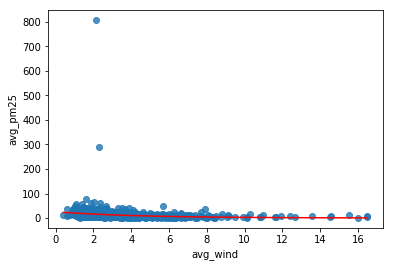

Curve Fit Model: PM25 = 25.5*exp(-0.2277*W)
Mean Squared Error: 776.6493711073825
Normalized Mean Squared Error: 0.9632680965216407


In [26]:
#PM25
def f(x, a, b):
    return a*np.exp(b*x)

df = pd.merge(wind_df, pm25_df, on=['date_local','latitude','longitude'])
df_sample = sample_data(df, 'avg_wind', 'avg_pm25', sample_size = 1000)
df_sample = df_sample.sort_values(by='avg_wind', ascending=False)
df_sample = df_sample[df_sample['avg_pm25']>0]
df_sample = df_sample[df_sample['avg_wind']<25]
x = df_sample['avg_wind'].astype(float)
y = df_sample['avg_pm25'].astype(float)
popt, pcov = curve_fit(f,x, y)
sns.regplot(x = 'avg_wind', y='avg_pm25', data = df_sample, fit_reg = False)
plt.plot(x, f(x, *popt),c='red')
plt.show()
mse = mean_squared_error(y, f(x, *popt))
nmse = mse/(np.max(y)-np.min(y))
print(f"Curve Fit Model: PM25 = {round(popt[0],2)}*exp({round(popt[1],4)}*W)")
print(f"Mean Squared Error: {mse}")
print(f"Normalized Mean Squared Error: {nmse}")

For the average finer particulate matter ($ < 2.5 \mu m$) and wind we observe a negative exponential relationship. The curve fit has a relatively low error, despite the high variance of average pm2.5 readings.

# **Pressure vs Pollutants Regression Analysis**

  Pollutant     Slope  Intercept        R2
0        CO  0.001784  -1.406609  0.043953
1      Lead  0.000014  -0.007001  0.001116
2       NO2  0.020721  -5.655733  0.001824
3       SO2 -0.001315   1.944933  0.004336
4        O3 -0.000119   0.150035  0.078058
5      PM10  0.074137 -43.477274  0.023694
6      PM25  0.040900 -27.991168  0.017908


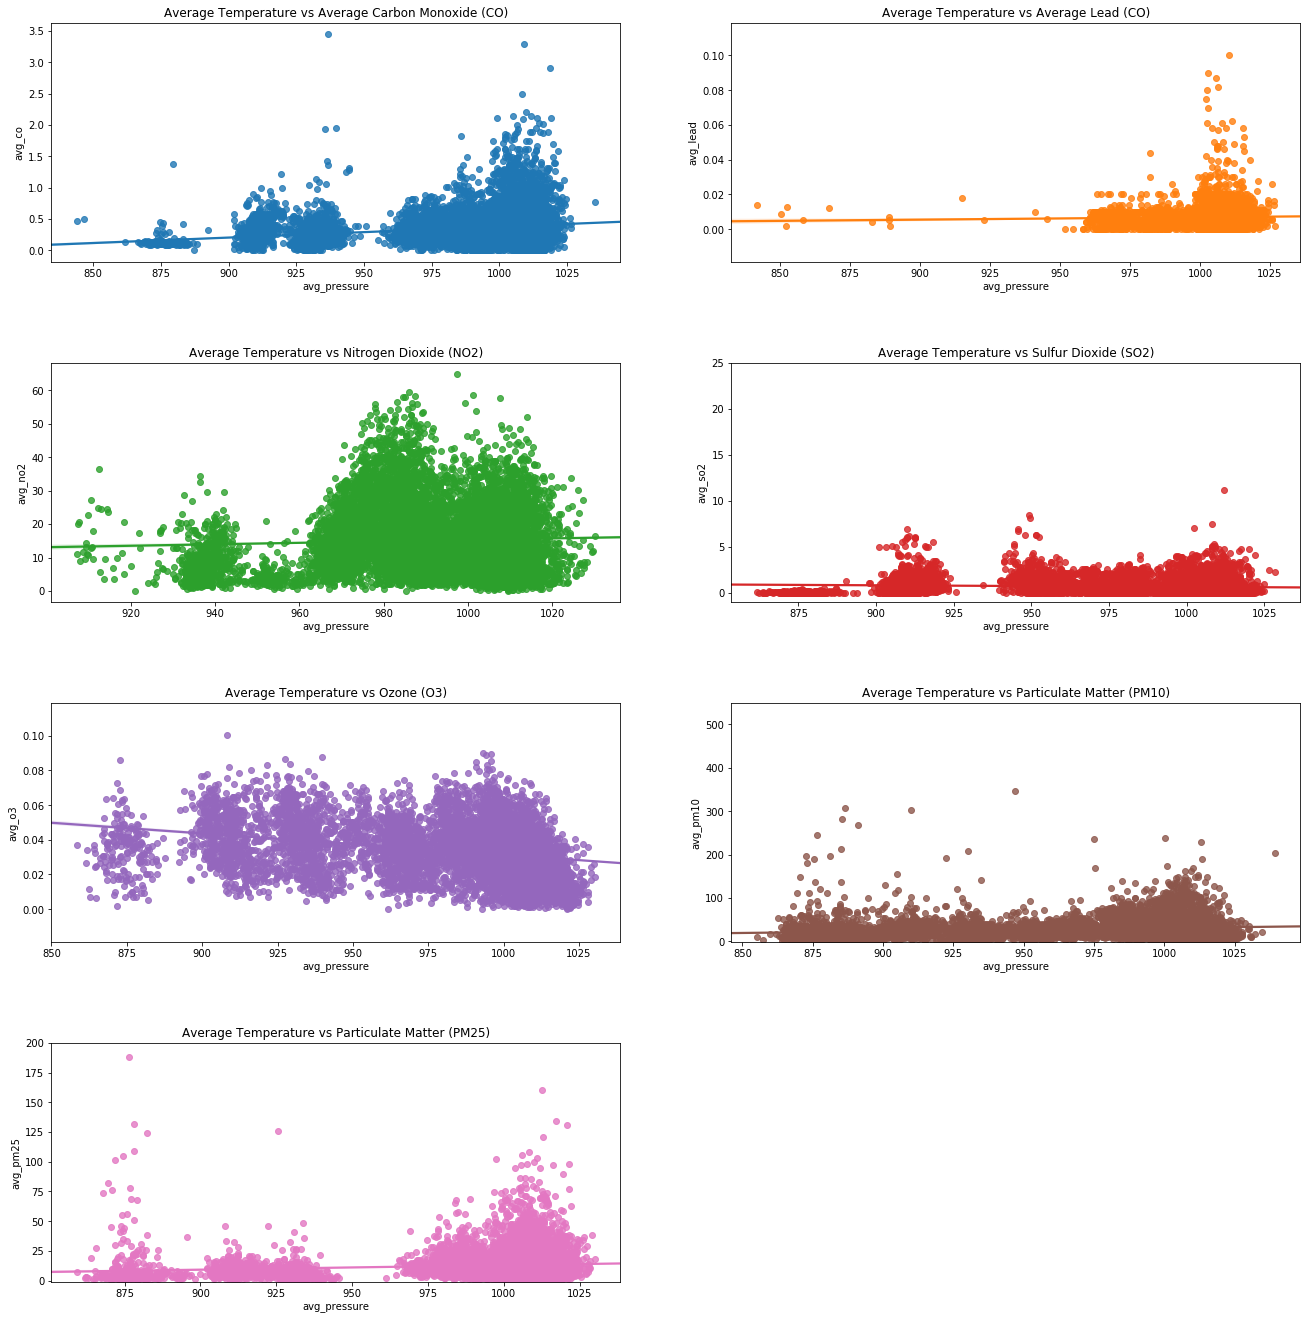

In [27]:
regstats=[]
fig, axes = plt.subplots(4, 2, figsize = (20,20))
fig.tight_layout(pad=8.0)

pressure_df = pressure_df[pressure_df['avg_pressure']>=750]
pressure_df = pressure_df[pressure_df['avg_pressure']<2000]
#CO
df = pd.merge(pressure_df, co_df, on=['date_local','latitude','longitude'])
df_sample = sample_data(df, 'avg_pressure', 'avg_co', sample_size = 10000)
sns.regplot(ax = axes[0][0] ,x='avg_pressure', y='avg_co', data=df_sample, fit_reg=True).set(title="Average Temperature vs Average Carbon Monoxide (CO)")
regstats.append(reg_stats(df, 'avg_pressure', 'avg_co'))
txt = "I need the caption to be present a little below X-axis"

#Lead
df = pd.merge(pressure_df, lead_df, on=['date_local','latitude','longitude'])
df_sample = sample_data(df, 'avg_pressure', 'avg_lead', sample_size = 10000)
regstats.append(reg_stats(df, 'avg_pressure', 'avg_lead'))
sns.regplot(ax = axes[0][1] ,x='avg_pressure', y='avg_lead', data=df_sample, fit_reg=True).set(title="Average Temperature vs Average Lead (CO)")

#Nitrogen Dioxide 
df = pd.merge(pressure_df, no2_df, on=['date_local','latitude','longitude'])
df_sample = sample_data(df, 'avg_pressure', 'avg_no2', sample_size = 10000)
regstats.append(reg_stats(df, 'avg_pressure', 'avg_no2'))
sns.regplot(ax = axes[1][0] ,x='avg_pressure', y='avg_no2', data=df_sample, fit_reg=True).set(title="Average Temperature vs Nitrogen Dioxide (NO2)")

#Sulfur Dioxide 
df = pd.merge(pressure_df, so2_df, on=['date_local','latitude','longitude'])
df = df.dropna(subset=['avg_pressure','avg_so2'])
df_sample = sample_data(df, 'avg_pressure', 'avg_so2', sample_size = 10000)
regstats.append(reg_stats(df, 'avg_pressure', 'avg_so2'))
sns.regplot(ax = axes[1][1] ,x='avg_pressure', y='avg_so2', data=df_sample, fit_reg=True).set(title="Average Temperature vs Sulfur Dioxide (SO2)")
axes[1][1].set(ylim=(-1, 25))

#Ozone 
df = pd.merge(pressure_df, o3_df, on=['date_local','latitude','longitude'])
df = df.dropna(subset=['avg_pressure','avg_o3'])
df_sample = sample_data(df, 'avg_pressure', 'avg_o3', sample_size = 10000)
regstats.append(reg_stats(df, 'avg_pressure', 'avg_o3'))
sns.regplot(ax = axes[2][0] ,x='avg_pressure', y='avg_o3', data=df_sample, fit_reg=True).set(title="Average Temperature vs Ozone (O3)")

#Particulate matter
df = pd.merge(pressure_df, pm10_df, on = ['date_local', 'latitude', 'longitude'])
df = df.dropna(subset=['avg_pressure','avg_pm10'])
df_sample = sample_data(df, 'avg_pressure', 'avg_pm10', sample_size = 10000)
regstats.append(reg_stats(df, 'avg_pressure', 'avg_pm10'))
sns.regplot(ax = axes[2][1] ,x='avg_pressure', y='avg_pm10', data=df_sample, fit_reg=True).set(title="Average Temperature vs Particulate Matter (PM10)")
axes[2][1].set(ylim=(-1, 550))

#Particulate matter
df = pd.merge(pressure_df, pm25_df, on = ['date_local', 'latitude', 'longitude'])
df = df.dropna(subset=['avg_pressure','avg_pm25'])
df_sample = sample_data(df, 'avg_pressure', 'avg_pm25', sample_size = 10000)
regstats.append(reg_stats(df, 'avg_pressure', 'avg_pm25'))
sns.regplot(ax = axes[3][0], x='avg_pressure', y='avg_pm25', data=df_sample, fit_reg=True).set(title="Average Temperature vs Particulate Matter (PM25)")
axes[3][0].set(ylim=(-1, 200))

axes[3][1].remove()
#combile regression statistics
regstats = np.array(regstats)
d = {'Pollutant':['CO','Lead','NO2','SO2','O3','PM10','PM25'], 'Slope':regstats[:,0], 'Intercept':regstats[:,1], 'R2':regstats[:,2]}
regression = pd.DataFrame(data = d)
regression = regression[['Pollutant', 'Slope', 'Intercept', 'R2']]
print(regression)

For our regresison analysis for pressure, we see a slight positive correlation between average pressure and average NO2, Lead, and particulate matter. We see a slight negative correlation between average barometric pressure and average Sulfur Dioxide and Ozone. From this, we can see if this would be a usefull predictor in a multivariate regression model that uses Temperature, Wind, and pressure to predict the 7 criteria air polutants we observe. 

# **Multivariate Regression Analysis**
Next, we aim to create an all encompasing, mulivariate regression model, where we can predict the average concentration of the 7 criteria air pollutants based off of the **Temperature, Wind, Pressure**, and **day of the year**. 

In [28]:
# add year day to each of the dataframes
temp_df['year_day'] = pd.to_datetime(temp_df['date_local'])
temp_df['year_day'] = temp_df['year_day'].dt.dayofyear
wind_df['year_day'] = pd.to_datetime(wind_df['date_local'])
wind_df['year_day'] = wind_df['year_day'].dt.dayofyear
pressure_df['year_day'] = pd.to_datetime(pressure_df['date_local'])
pressure_df['year_day'] = pressure_df['year_day'].dt.dayofyear

co_df['year_day'] = pd.to_datetime(co_df['date_local'])
co_df['year_day'] = co_df['year_day'].dt.dayofyear
lead_df['year_day'] = pd.to_datetime(lead_df['date_local'])
lead_df['year_day'] = lead_df['year_day'].dt.dayofyear
no2_df['year_day'] = pd.to_datetime(no2_df['date_local'])
no2_df['year_day'] = no2_df['year_day'].dt.dayofyear
so2_df['year_day'] = pd.to_datetime(so2_df['date_local'])
so2_df['year_day'] = so2_df['year_day'].dt.dayofyear
o3_df['year_day'] = pd.to_datetime(o3_df['date_local'])
o3_df['year_day'] = o3_df['year_day'].dt.dayofyear
pm10_df['year_day'] = pd.to_datetime(pm10_df['date_local'])
pm10_df['year_day'] = pm10_df['year_day'].dt.dayofyear
pm25_df['year_day'] = pd.to_datetime(pm25_df['date_local'])
pm25_df['year_day'] = pm25_df['year_day'].dt.dayofyear

First we add the day of the year that the pollutant measurement took place, with day 1 being January 1. 

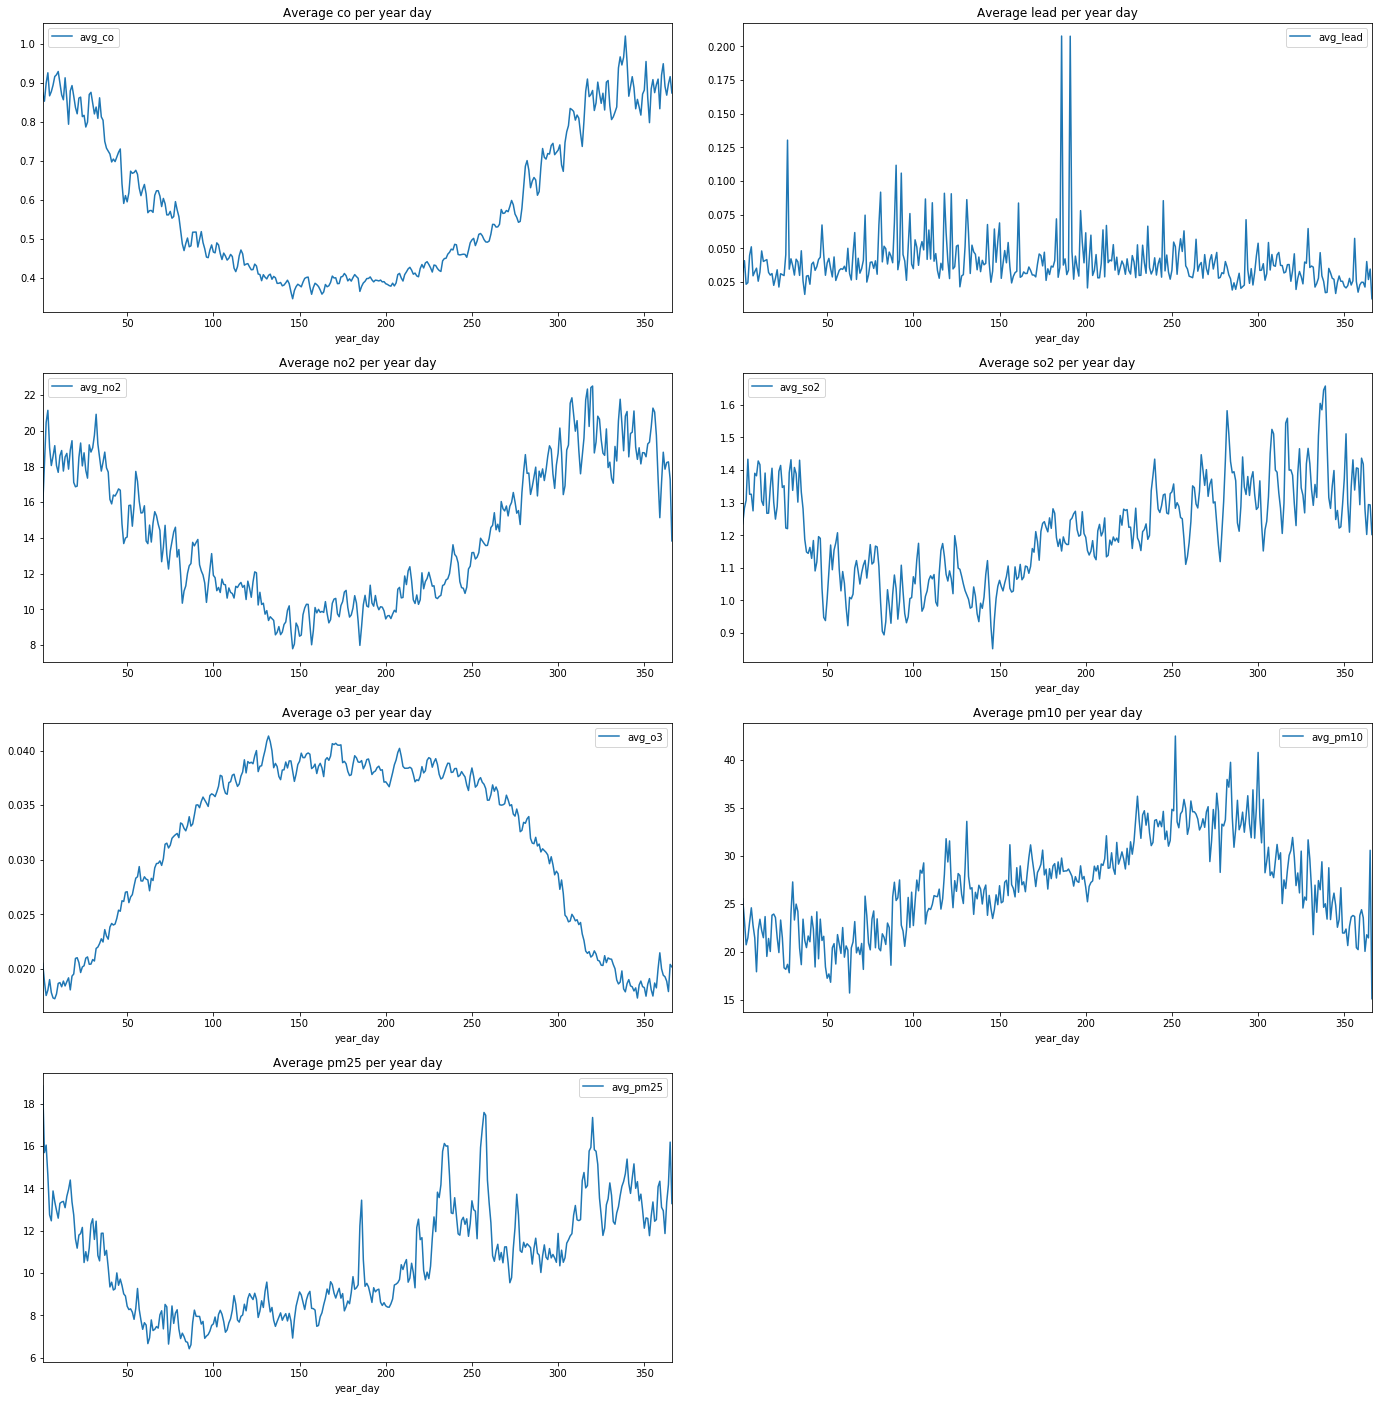

In [29]:
#observe the average concentration of pollutants based on the day of the year
df_list = [co_df, lead_df, no2_df, so2_df, o3_df, pm10_df, pm25_df]

fig, axes = plt.subplots(4, 2, figsize = (20,20))
fig.tight_layout(pad=4.0)

r = -1 # used to get subplot row right
for i, df in enumerate(df_list): 
    y_col = df.columns[3]
    grouping_df = df.groupby('year_day').mean()
    if i%2 == 0: 
        r += 1
    grouping_df.plot(ax = axes[r][int(i%2!=0)] ,x=grouping_df.index, y=y_col).set(title=f"Average {y_col[4:]} per year day")
    
axes[3][1].remove()

Since the time of year seems to have a strong effect on the concentration of the pollutants, we will use this as an input in our predictive model. 

# **Multiple Regression Model**

In [30]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [31]:
#combined df of 6 criteria pollutants
weather_df = pd.merge(temp_df, wind_df, on=['date_local','latitude','longitude','year_day'])
weather_df = pd.merge(weather_df, pressure_df, on=['date_local','latitude','longitude','year_day'])
print(weather_df.head())
print(np.shape(weather_df))

   date_local   latitude   longitude   avg_temp  year_day  avg_wind  \
0  1999-08-02  39.757371 -121.843286  76.166667       214  2.291667   
1  1999-08-03  39.757371 -121.843286  77.875000       215  1.958333   
2  1999-08-10  39.757371 -121.843286  68.166667       222  1.916667   
3  1999-08-12  39.757371 -121.843286  72.458333       224  2.291667   
4  1999-08-13  39.757371 -121.843286  70.083333       225  2.958333   

   avg_pressure  
0   1007.895833  
1   1007.387500  
2   1002.025000  
3   1007.333333  
4   1005.516667  
(235011, 7)


In [32]:
#multilinear regression using weather. Returns model, mse, mae
def multilinear_reg(df, test_size = 0.5):
    df = pd.merge(df, weather_df, on=['date_local','latitude','longitude','year_day'])
    X = df[['year_day','avg_temp','avg_wind','avg_pressure']]
    y = df[df.columns[3]]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)

    predicted = regr.predict(X_test)

    mse = mean_squared_error(y_test, predicted)
    mae = mean_absolute_error(y_test, predicted)
    nmse = mse/(np.max(y_test)-np.min(y_test))
    
    return regr, mse, mae, nmse

In [33]:
#creating a multivariate regression model for each of the 
df_list = [co_df, o3_df, lead_df, no2_df, so2_df, pm10_df, pm25_df]
reg_models, mse_arr, mae_arr, nmse_arr = [],[],[],[]

for df in df_list: 
    reg, mse, mae, nmse = multilinear_reg(df)
    reg_models.append(reg)
    mse_arr.append(mse)
    mae_arr.append(mae)
    nmse_arr.append(nmse)

reg_models_summary = pd.DataFrame(data = {'Model':['CO','O3','Lead','NO2','SO2','PM10','PM25'],'MSE':mse_arr,'MAE':mae_arr,'NMSE':nmse_arr})
reg_models_summary = reg_models_summary[['Model','MSE','MAE','NMSE']]  
print(reg_models_summary)
print(f"Total model normalized mean square error: {np.mean(reg_models_summary['NMSE'])}")

#returns predicted CO, O3, Lead, NO2, SO2, PM10, PM25 in that order. 
def predict(weather_df):
    res = []
    for reg in reg_models: 
        res.extend(reg.predict(weather_df))
    return res

#example of prediction output
print(predict(np.reshape([10.,55.,4.,1000.],(1,-1))))    

  Model         MSE        MAE      NMSE
0    CO    0.065134   0.170761  0.016737
1    O3    0.000091   0.007481  0.000903
2  Lead    0.000046   0.004296  0.000465
3   NO2   89.706191   7.497387  1.255364
4   SO2    0.596368   0.521008  0.053383
5  PM10  516.086906  13.890972  0.637144
6  PM25  120.314536   6.758853  0.446105
Total model normalized mean square error: 0.34430009172485193
[0.33869814086475492, 0.028170802248189894, 0.0058133287619177923, 12.606764250737214, 0.57918992051475193, 20.170988698391199, 10.738937099641729]


With this model, we are able to predict all of the criteria air pollutants within reasonable accuracy based off only the day of the year, the average temperature, average wind speed, and average atmospheric pressure. These air pollutants provide a more detailed look at the air quality than AQI alone, and are used to calculate AQI: https://www.airnow.gov/aqi/aqi-calculator/. 